In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [51]:
DATASET_PATH = "/home/vineet/datasets/rock-paper-scissors-dataset/Rock-Paper-Scissors/"

In [52]:
TRAIN_PATH = DATASET_PATH + "train/"
TEST_PATH = DATASET_PATH + "test/"
VALIDATION_PATH = DATASET_PATH + "validation/"

In [53]:
CLASS_NAMES = ['paper', 'rock', 'scissors']

### Image Loaging and Augmentation Functions

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=30,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
    # validation_split=0.15,
)

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [55]:
train_images = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training',
)

# val_images = test_generator.flow_from_directory(
#     TRAIN_PATH,
#     target_size=(128, 128),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=64,
#     shuffle=True,
#     seed=42,
#     subset='validation',
# )


test_images = test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
)
val_images = test_images

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


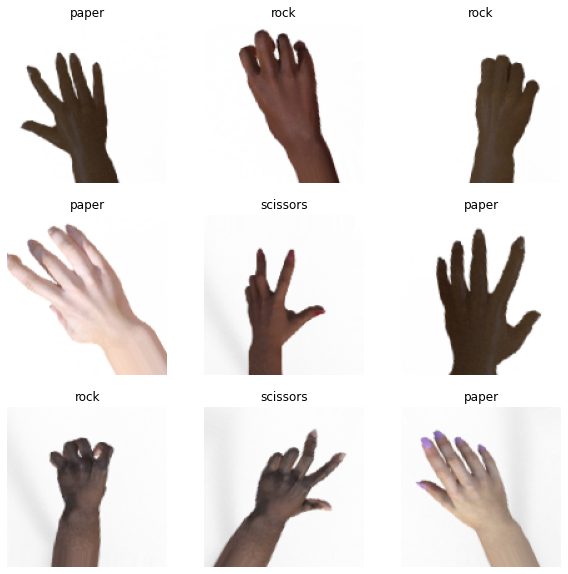

In [56]:
plt.figure(figsize=(10, 10))

images, labels = train_images.next()
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

### Model Generation

In [57]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, log_loss
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pathlib

In [58]:
TRAIN_MODELS = False
NUM_CLASSES = len(CLASS_NAMES)
MODEL_PATH = pathlib.Path("/home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/")
INPUT_SHAPE = train_images.target_size + (3,)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications

weight_decay = 1e-5
LEARNING_RATE = 4e-4
learning_rate_decay_rate = 0.1

def create_model(model_backbone: str, model_name:str=None, layers=[256]):
    model_name = model_name or model_backbone
    model = Sequential(name=model_name)
    
    model_backbone = get_model_backbone(model_backbone)
    model_backbone.trainable = False
    model.add(model_backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.2))
    
    for layer_size in layers:
        model.add(Dense(layer_size, kernel_regularizer=l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(0.3))
    
    model.add(Activation("relu"))
    
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

def get_model_backbone(model_backbone: str):
    if model_backbone == "VGG16":
        model_backbone = applications.VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "VGG19":
        model_backbone = applications.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet50V2":
        model_backbone = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet101V2":
        model_backbone = applications.ResNet101V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet152V2":
        model_backbone = applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionV3":
        model_backbone = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionResNetV2":
        model_backbone = applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "Xception":
        model_backbone = applications.Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenselNet121":
        model_backbone = applications.DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenselNet169":
        model_backbone = applications.DenseNet169(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenselNet201":
        model_backbone = applications.DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNet":
        model_backbone = applications.MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNetV2":
        model_backbone = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
        
    return model_backbone

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger


monitor_metric = 'val_accuracy'
# learning_rate_decay_rate = 0.06
def get_callbacks():
    callbacks = {}
    
    callbacks["EarlyStopping"] = EarlyStopping(
            monitor=monitor_metric,
            patience=5,
            mode = "auto",
            verbose=1,
        )
    
    callbacks["LearningRateScheduler"] = LearningRateScheduler(step_decay)

    callbacks["ModelCheckpoint"] = ModelCheckpoint(
            MODEL_PATH / f"{model.name}.h5",
            monitor=monitor_metric,
            save_best_only=True,
            mode='auto',
            verbose=1,
    )
    
    return callbacks


def step_decay(epoch):
    initial_lr = LEARNING_RATE
    k = learning_rate_decay_rate
    lr = initial_lr * np.exp(-k*epoch)
    return lr

def compute_performance_metrics(model, test_images_, print_report=True):
    labels = test_images_.labels
    labels_cat = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    pred_cat = model.predict(test_images_)
    pred = model.predict(test_images_).argmax(axis=1)
    
    performance_metrics = {}
    performance_metrics["accuracy"] = accuracy_score(labels, pred)
    performance_metrics["f1_score"] = f1_score(labels, pred, average="macro")
    performance_metrics["precision"] = precision_score(labels, pred, average="macro")
    performance_metrics["recall"] = recall_score(labels, pred, average="macro")
    performance_metrics["loss"] = log_loss(labels_cat, pred_cat)
    
    performance_df.loc[model.name] = performance_metrics
    if print_report:
        return performance_df.loc[model.name]

performance_df = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1_score", "loss"])

In [61]:
backbone_model = "VGG16"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_12  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_313 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_321 (Activation)  (None, 256)              0     

In [62]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=30,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

VGG16 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/VGG16.h5


In [63]:
compute_performance_metrics(model, test_images)


accuracy     0.994624
precision    0.994645
recall       0.994624
f1_score     0.994624
loss         0.500879
Name: VGG16, dtype: float64

In [64]:
backbone_model = "VGG19"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_13  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_314 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_323 (Activation)  (None, 256)              0     

In [65]:
train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=30,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

VGG19 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/VGG19.h5


In [66]:
compute_performance_metrics(model, test_images)

accuracy     0.970430
precision    0.972153
recall       0.970430
f1_score     0.970189
loss         0.166951
Name: VGG19, dtype: float64

In [67]:
backbone_model = "ResNet50V2"
model = create_model(backbone_model)
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.05

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_14  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_28 (Dropout)        (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_315 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_325 (Activation)  (None, 256)              0

In [68]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=35,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet50V2 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/ResNet50V2.h5


In [69]:
compute_performance_metrics(model, test_images)

accuracy     0.895161
precision    0.904957
recall       0.895161
f1_score     0.894811
loss         0.284016
Name: ResNet50V2, dtype: float64

In [70]:
backbone_model = "ResNet101V2"
model = create_model(backbone_model)
# LEARNING_RATE = 35e-6
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
# model.summary()

In [71]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=40,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet101V2 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/ResNet101V2.h5


In [72]:
compute_performance_metrics(model, test_images)

accuracy     0.922043
precision    0.930339
recall       0.922043
f1_score     0.919738
loss         0.175804
Name: ResNet101V2, dtype: float64

In [1]:
backbone_model = "ResNet152V2"
model = create_model(backbone_model)
# LEARNING_RATE = 5e-5
# learning_rate_decay_rate = 0.1

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

NameError: name 'create_model' is not defined

In [74]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=35,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet152V2 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/ResNet152V2.h5


In [75]:
compute_performance_metrics(model, test_images)

accuracy     0.645161
precision    0.686232
recall       0.645161
f1_score     0.621166
loss         0.925190
Name: ResNet152V2, dtype: float64

In [76]:
backbone_model = "InceptionV3"
model = create_model(backbone_model)
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.072

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_34 (Dropout)        (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_412 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_425 (Activation)  (None, 256)              

In [77]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=35,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

InceptionV3 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/InceptionV3.h5


In [78]:
compute_performance_metrics(model, test_images)

accuracy     0.911290
precision    0.914459
recall       0.911290
f1_score     0.910253
loss         0.227657
Name: InceptionV3, dtype: float64

In [79]:
backbone_model = "InceptionResNetV2"
model = create_model(backbone_model)
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_18  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_36 (Dropout)        (None, 1536)              0         
                                                                 
 dense_36 (Dense)            (None, 256)               393472    
                                                                 
 batch_normalization_616 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                 

In [80]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=40,#
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

InceptionResNetV2 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/InceptionResNetV2.h5


In [81]:
compute_performance_metrics(model, test_images)

accuracy     0.779570
precision    0.834848
recall       0.779570
f1_score     0.747919
loss         0.546559
Name: InceptionResNetV2, dtype: float64

In [82]:
backbone_model = "Xception"
model = create_model(backbone_model)
# LEARNING_RATE = 35e-6
# learning_rate_decay_rate = 0.078

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_38 (Dropout)        (None, 2048)              0         
                                                                 
 dense_38 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_621 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_632 (Activation)  (None, 256)              0  

In [83]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=40,#
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

Xception model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/Xception.h5


In [84]:
compute_performance_metrics(model, test_images)

accuracy     0.814516
precision    0.833678
recall       0.814516
f1_score     0.809974
loss         0.409831
Name: Xception, dtype: float64

In [85]:
backbone_model = "DenselNet121"
model = create_model(backbone_model)
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.075

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "DenselNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_20  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_40 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_622 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_634 (Activation)  (None, 256)             

In [86]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=45,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenselNet121 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/DenselNet121.h5


In [87]:
compute_performance_metrics(model, test_images)

accuracy     0.919355
precision    0.928727
recall       0.919355
f1_score     0.919239
loss         0.247675
Name: DenselNet121, dtype: float64

In [88]:
backbone_model = "DenselNet169"
model = create_model(backbone_model)
# LEARNING_RATE = 3e-5
# learning_rate_decay_rate = 0.06

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "DenselNet169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 global_average_pooling2d_21  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_42 (Dropout)        (None, 1664)              0         
                                                                 
 dense_42 (Dense)            (None, 256)               426240    
                                                                 
 batch_normalization_623 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_636 (Activation)  (None, 256)             

In [89]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=35,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenselNet169 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/DenselNet169.h5


In [90]:
compute_performance_metrics(model, test_images)

accuracy     0.913978
precision    0.916608
recall       0.913978
f1_score     0.912728
loss         0.246437
Name: DenselNet169, dtype: float64

In [91]:
backbone_model = "DenselNet201"
model = create_model(backbone_model)
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.065

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "DenselNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d_22  (None, 1920)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_44 (Dropout)        (None, 1920)              0         
                                                                 
 dense_44 (Dense)            (None, 256)               491776    
                                                                 
 batch_normalization_624 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_638 (Activation)  (None, 256)             

In [92]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=40,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenselNet201 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/DenselNet201.h5


In [93]:
compute_performance_metrics(model, test_images)         #[0.7855522036552429, 0.75]

accuracy     0.935484
precision    0.940582
recall       0.935484
f1_score     0.934703
loss         0.260425
Name: DenselNet201, dtype: float64

In [94]:
backbone_model = "MobileNetV2"
model = create_model(backbone_model)
# LEARNING_RATE = 42e-6
# learning_rate_decay_rate = 0.078

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_23  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_46 (Dropout)        (None, 1280)              0         
                                                                 
 dense_46 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_625 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                       

In [95]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=30,
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

MobileNetV2 model loaded from /home/vineet/.personal/code/Rock_Paper_Scissors-Image_Recognition/models/MobileNetV2.h5


In [96]:
compute_performance_metrics(model, test_images)

accuracy     0.986559
precision    0.987080
recall       0.986559
f1_score     0.986554
loss         0.075277
Name: MobileNetV2, dtype: float64

In [98]:
performance_df.sort_values(by="accuracy", ascending=False)

,accuracy,precision,recall,f1_score,loss
VGG16,0.994624,0.994645,0.994624,0.994624,0.500879
MobileNetV2,0.986559,0.987080,0.986559,0.986554,0.075277
VGG19,0.970430,0.972153,0.970430,0.970189,0.166951
DenselNet201,0.935484,0.940582,0.935484,0.934703,0.260425
ResNet101V2,0.922043,0.930339,0.922043,0.919738,0.175804
DenselNet121,0.919355,0.928727,0.919355,0.919239,0.247675
DenselNet169,0.913978,0.916608,0.913978,0.912728,0.246437
InceptionV3,0.911290,0.914459,0.911290,0.910253,0.227657
ResNet50V2,0.895161,0.904957,0.895161,0.894811,0.284016
Xception,0.814516,0.833678,0.814516,0.809974,0.409831
